In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("https://github.com/mlefkir/beauxgraphs/raw/main/beautifulgraphs_colblind.mplstyle")

# On the Fast Fourier Transform to compute the autocovariance

Here we show the effects of computing the autocovariance function (ACVF) using the Fast Fourier Transform. We will show these effects using functions where we know the analytical Fourier Transform. Which are the exponential and squared exponential autocovariance functions. First we compute the ACVF on an arbitrary grid and then we compute the ACVF on an extended grid of frequencies.

|  | Autocovariance $R(\tau)$ | Power spectrum $\mathcal{P}(f)$ |
| --- | ----------- | -- |
| Exponential | $\dfrac{A}{2\gamma} \exp{(-\|\tau\|\gamma)}$ | $\dfrac{A}{\gamma^2 +4\pi^2 f^2}$ |
| Squared exponential | $A\exp{(-2 \pi^2 \tau^2 \sigma^2)}$ | $\dfrac{A}{\sqrt{2\pi}\sigma}$ $\exp\left(-\dfrac{f^2}{2\sigma^2} \right)$ |

## Arbitrary grid of frequencies

### Squared exponential ACVF

First, we define the autocovariance function and its Fourier transform, i.e. the power spectrum.

In [2]:
def SqExpo_ACV(t, A, sigma):
    return A * np.exp( -2 * np.pi**2 * sigma**2 * t**2 )

def SqExpo_PSD(f, A, sigma):
    return A / (np.sqrt(2*np.pi) * sigma ) * np.exp( - 0.5 * f**2 / sigma**2 )

We generate a grid of frequencies from $0$ to $f_N$ with a spacing $\Delta f=f_0$. The power spectrum will be of length $N$.

In [3]:
f0 = 1e-4 # min frequency 
df = f0 
fN = 5. # max frequency
# grid of frequencies, from 0 to fend-df with step size df
f = np.arange(0,fN,df)
# number of points in the psd including the zeroth freq
N = len(f)
# define the parameters of the psd
A , sigma = 1 , 1.e-1

P = SqExpo_PSD(f,A,sigma)

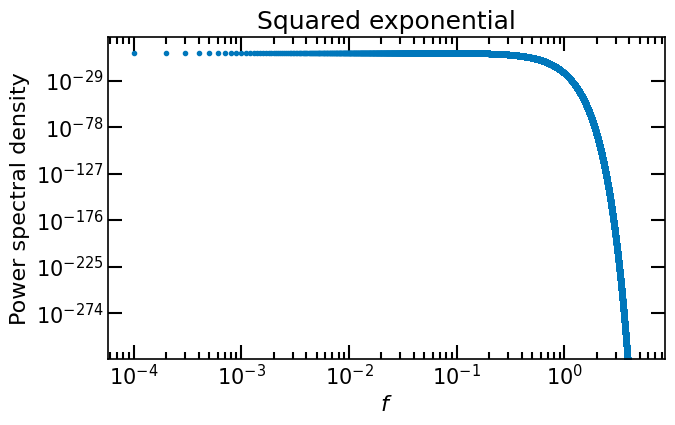

In [4]:
fig,ax = plt.subplots(1,1,figsize=(7,4.5))
ax.plot(f,P,'.')
ax.set_xlabel(r'$f$')
ax.set_ylabel('Power spectral density')
ax.loglog()
ax.set_title("Squared exponential")
fig.tight_layout()

As we know the power spectrum is symmetric for negative frequencies, we can use the real inverse Fourier transform to compute the autocovariance function. 

We use the function [```np.fft.irfft```](https://numpy.org/doc/stable/reference/generated/numpy.fft.irfft.html) to compute the inverse Fourier transform. The discrete inverse Fourier transform returns a real array of length $2N-2$. Where ```x[0]``` is the autocovariance at $\tau=0$ and ```x[N-1]``` is the autocovariance at $\tau=\tau_\mathrm{max}$, after which the autocovariance is mirrored for negative lags. The time separation between the autocovariance values is given by $\Delta \tau = \tau_\mathrm{max}/(N-1)$, where $\tau_\mathrm{max}=1/2\Delta f$ is the maximum lag for which we compute the autocovariance function.

To obtain the true autocovariance function we divide the result by the sampling frequency $\Delta f$.

In [5]:
tmax = 0.5 / df 
dt = 1/df/(N-1)/2

t = np.arange(0,tmax+dt,dt)

R_theo = SqExpo_ACV(t,A,sigma) # theoretical inverse FT of the lorentzian

# compute the IFFT, with a normalisation factor 1/M, M=2*(len(y)-1)
R_dift = np.fft.irfft(P) 
assert (R_dift[1:N-1]-np.flip(R_dift[N:])<np.finfo(float).eps).all(), "The IRFFT did not return a mirrored ACV"
R_num = R_dift[:N]/dt

Below, we plot the resulting autocovariance function and the error between the numerical and analytical autocovariance function. For plotting purposes, we only plot the autocovariance function for positive lags and up to $\tau=10$.

We can see that in the case of the squared exponential autocovariance function, the numerical Fourier transform is exact within the numerical precision.

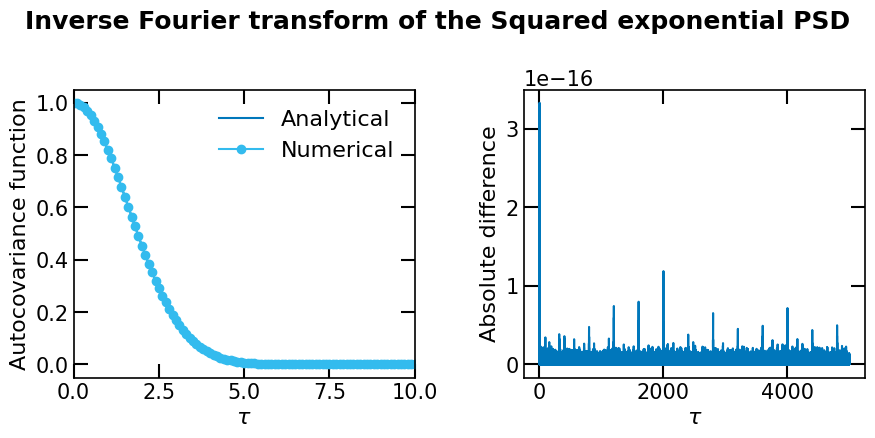

In [6]:
fig,ax = plt.subplots(1,2,figsize=(9,4.5))
ax[0].plot(t,R_theo,label='Analytical')#,marker='s')
ax[0].plot( t, R_num,label='Numerical',marker='o')

ax[0].legend()
ax[0].set_xlim(-1e-5,10 )
ax[0].set_xlabel(r"$\tau$")
ax[0].set_ylabel(r"Autocovariance function")
ax[1].plot(t,np.abs(R_theo-R_num),label='|Error|')#,marker='s')

ax[1].set_xlabel(r"$\tau$")
ax[1].set_ylabel(r"Absolute difference")
fig.suptitle("Inverse Fourier transform of the Squared exponential PSD")
fig.tight_layout()

We can check the Fourier pairs properties of the autocovariance function and the power spectrum by comparing the sums.

In [7]:
print(f"P(0)           : {P[0]:1.5e}")
print(f'Sum of ACV     : {np.trapz(R_num)*dt*2:1.5e}')
print(f'Sum of ACVtheo : {np.trapz(R_theo)*dt*2:1.5e}')
print(f"------Error----: {np.abs(np.trapz(R_num)*2*dt-P[0]):1.5e}\n")

print(f'Sum of PSD     : {np.trapz(P)*df*2:1.3e}')
print(f'ACVtheo[0]     : {(R_theo[0]):1.3e}')
print(f'ACV[0]         : {R_num[0]:1.3e}')
print(f"-----Error-----: {np.abs(np.trapz(P)*2*df-R_num[0]):1.3e}\n")

P(0)           : 3.98942e+00
Sum of ACV     : 3.98942e+00
Sum of ACVtheo : 3.98942e+00
------Error----: 1.33227e-15

Sum of PSD     : 1.000e+00
ACVtheo[0]     : 1.000e+00
ACV[0]         : 1.000e+00
-----Error-----: 0.000e+00



### Exponential ACVF

In [8]:
def Expo_PSD(f, A, gamma):
    return A / ( (4*np.pi**2 * f**2 + gamma**2) )
def Expo_ACV(t, A, gamma):
    return 0.5* A / gamma * np.exp( - gamma * t )

In [9]:
f0 = 1e-3
df = f0 
fN = 1. # max frequency
f = np.arange(0,fN,df)
N = len(f)
A , sigma = 1 , 1e-1
P = Expo_PSD(f,A,sigma)

Unlike in the previous case, the power spectrum is less steep, it does not decay as fast to zero. This means that the autocovariance function at the firs time lags will be more affected by the numerical Fourier transform.

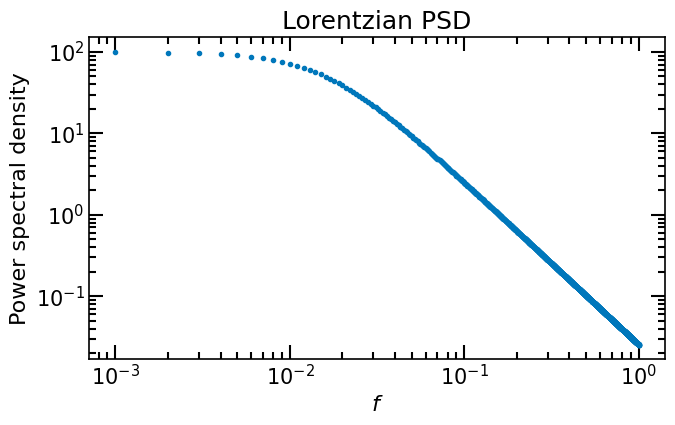

In [10]:
fig,ax = plt.subplots(1,1,figsize=(7,4.5))
ax.plot(f,P,'.')
ax.set_xlabel(r'$f$')
ax.set_ylabel('Power spectral density')
ax.loglog()
ax.set_title("Lorentzian PSD")
fig.tight_layout()

In [11]:
tmax = 0.5 / df 
dt = 1/df/(N-1)/2

t = np.arange(0,tmax+dt,dt)

R_theo = Expo_ACV(t,A,sigma)

# compute the IFFT, with a normalisation factor 1/M, M=2*(len(y)-1)
R_dift = np.fft.irfft(P) 
# assert (R_dift[1:N-1]-np.flip(R_dift[N:])<np.finfo(float).eps).all(), "The IRFFT did not return a mirrored ACV"
R_num = R_dift[:N]/dt

We see that this time FFT does not give an exact result within the numerical precision, this is due to the power spectrum does not decay as fast to zero as in the case of the squared exponential autocovariance function. The Discrete Fourier Transform assumes the signal is periodic, the power spectrum is replicated at the end of the grid of frequencies but because the power spectrum does not decay to zero, the aliasing effect is more important. We will see how to mitigate this effect in the next section.

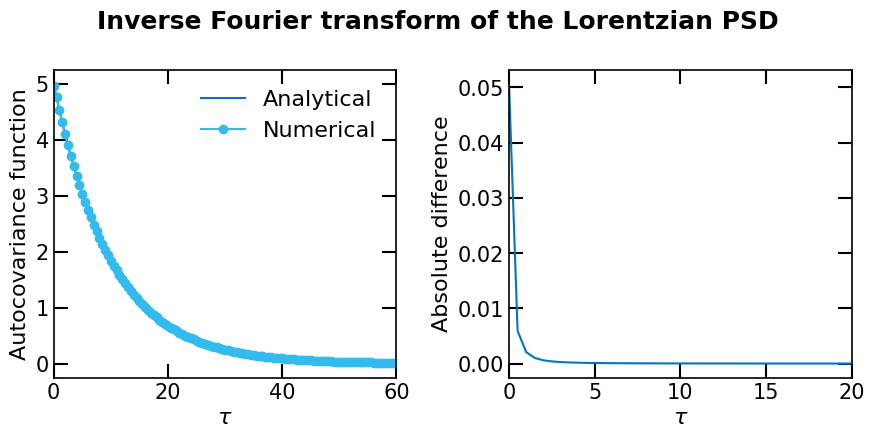

In [12]:
fig,ax = plt.subplots(1,2,figsize=(9,4.5))
ax[0].plot(t,R_theo,label='Analytical')
ax[0].plot( t, R_num,label='Numerical',marker='o')

ax[0].legend()
ax[0].set_xlim(-1e-5,60 )
ax[0].set_xlabel(r"$\tau$")
ax[0].set_ylabel(r"Autocovariance function")
ax[1].plot(t,np.abs(R_theo-R_num),label='|Error|')#,marker='s')

ax[1].set_xlabel(r"$\tau$")
ax[1].set_ylabel("Absolute difference")
ax[1].set_xlim(-1e-5,20 )

fig.suptitle("Inverse Fourier transform of the Lorentzian PSD")
fig.tight_layout()

In [13]:
print(f"P(0)           : {P[0]:1.5e}")
print(f'Sum of ACV     : {np.trapz(R_num)*dt*2:1.5e}')
print(f'Sum of ACVtheo : {np.trapz(R_theo)*dt*2:1.5e}')
print(f"------Error----: {np.abs(np.trapz(R_num)*2*dt-P[0]):1.5e}\n")

print(f'Sum of PSD     : {np.trapz(P)*df*2:1.3e}')
print(f'ACVtheo[0]     : {(R_theo[0]):1.3e}')
print(f'ACV[0]         : {R_num[0]:1.3e}')
print(f"-----Error-----: {np.abs(np.trapz(P)*2*df-R_num[0]):1.3e}\n")

P(0)           : 1.00000e+02
Sum of ACV     : 1.00000e+02
Sum of ACVtheo : 1.00021e+02
------Error----: 2.84217e-14

Sum of PSD     : 4.949e+00
ACVtheo[0]     : 5.000e+00
ACV[0]         : 4.949e+00
-----Error-----: 0.000e+00



## Extending the grid of frequencies

As we saw in the previous section, the autocovariance obtained via FFT on a grid of frequencies can be affected by the aliasing effect. To mitigate this effect, we can extend the grid of frequencies. 

Let us consider the case of a signal of duration $T=400$ with a sampling period of $\Delta T=1$. We want to compute the ACVF of the signal given our two PSD models. The minimal grid of frequencies to compute the ACVF is $f_\mathrm{min}=1/T$ and the maximal grid of frequencies is given by the Nyquist frequency $f_\mathrm{max}=1/2\Delta T$.
As we saw in the previous section, the autocovariance obtained via FFT on a grid of frequencies can be affected by aliasing. 

To mitigate this effect, we extend the grid of frequencies with two factors: $S_\mathrm{low}$ and $S_\mathrm{high}$, for low and high frequencies, respectively. The grid of frequencies is then given by $f_0 = f_\mathrm{min}/S_\mathrm{low} = \Delta f$ to $f_N = f_\mathrm{max}S_\mathrm{high}=N \Delta f$.

```{eval-rst}
.. tikz:: 
    :xscale: 90

    [thick]

    \draw (0,2pt) -- + (0,-2pt) node[below=1mm] {0};
    \draw (.5,2pt) -- + (0,-2pt) node[below=1mm] {$f_0$};
    \draw (3.5,5pt) -- + (0,-5pt) node[below=1mm] {$f_\mathrm{min}$};
    \draw (10.,5pt) -- + (0,-5pt) node[below=1mm] {$f_\mathrm{max}$};
    \draw (14,5pt) -- + (0,-5pt) node[below=1mm] {$f_\mathrm{N}$};
    \draw[thick] (0,0) -- node[below=7mm] {Frequency $f$} + (15,0);
    \foreach \x in {0,0.5,...,14.}
       \draw (\x cm,3pt) -- (\x cm,-3pt) node[anchor=north] {};
```

In [14]:
T = 400
dT = 1
f_min = 1/T
f_max = .5/dT

### Extending the high frequencies

First, we start by studying the effect of $S_\mathrm{high}$ on the autocovariance function. We will use the exponential autocovariance function as an example. 

To obtain the values of the autocovariance function up to lag $\tau=T$ (time separation between the first and last value), $S_\mathrm{low}$ should be larger than $2$. This is due to $\tau_\mathrm{max}=1/2\Delta f$ and $\Delta f=f_0=\frac{1}{S_\mathrm{low}T}$.

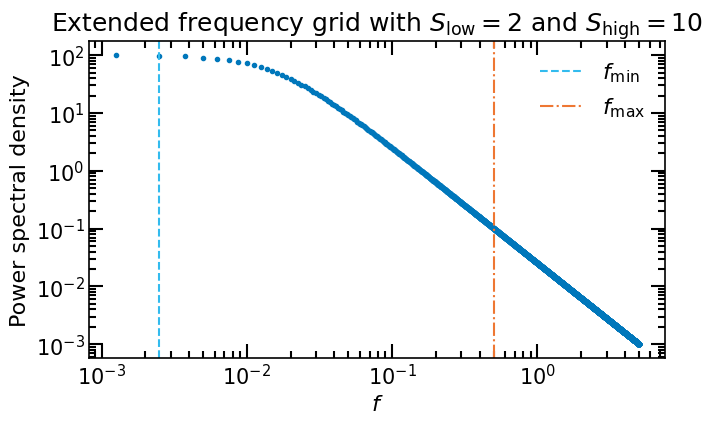

In [15]:
S_low = 2
S_high = 10

f0 = f_min/S_low
df = f0
fN = f_max*S_high # max frequency
# grid of frequencies, from 0 to fend-df with step size df
f = np.arange(0,fN,f0)
# number of points in the psd including the zeroth freq
N = len(f)
# define the parameters of the psd
A , sigma = 1 , 1e-1

P = Expo_PSD(f,A,sigma)

fig,ax = plt.subplots(1,1,figsize=(7,4.5))
ax.plot(f,P,'.')
ax.set_xlabel(r'$f$')
ax.set_ylabel('Power spectral density')
ax.loglog()
ax.set_title("Extended frequency grid with $S_\mathrm{low}=%i$ and $S_\mathrm{high}=%i$"%(S_low,S_high))
ax.axvline(f_min,ls='--',color='C1',label=r'$f_\mathrm{min}$')
ax.axvline(f_max,ls='-.',color='C3',label=r'$f_\mathrm{max}$')
ax.legend()
fig.tight_layout()

For several values of $S_\mathrm{high}$, we compute the autocovariance function and the error between the numerical and analytical autocovariance function. We plot the absolute difference up to $\tau_\mathrm{max}$ with an inset for lags up to $\tau=10$.

The error at the first lags and all other lags is decreasing as $S_\mathrm{high}$ increases, this reduces aliasing, the power spectrum at high frequencies is slowly reaching zero as more frequencies are added. Also the error appears to attain a plateau for high values of $\tau$, a plateau which is always smaller for higher values of $S_\mathrm{high}$.

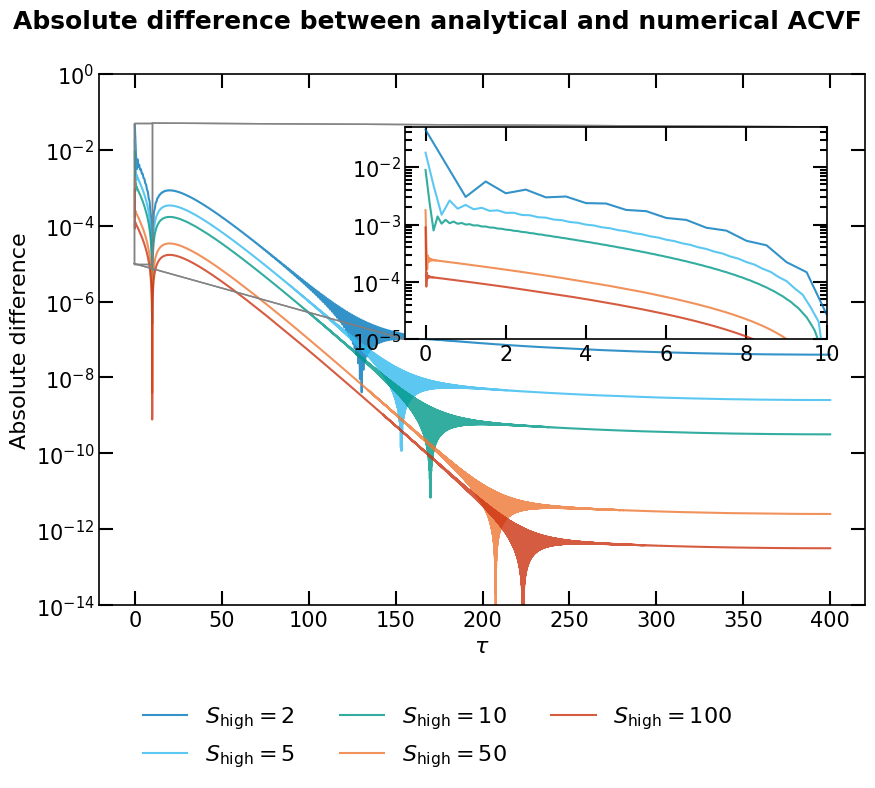

In [16]:
fig,ax = plt.subplots(1,1,figsize=(9,7.5))

for i,S_high in enumerate([2,5,10,50,100]):

    f0 = f_min/S_low
    df = f0
    fN = f_max*S_high # max frequency
    # grid of frequencies, from 0 to fend-df with step size df
    f = np.arange(0,fN,f0)
    # number of points in the psd including the zeroth freq
    N = len(f)
    # define the parameters of the psd
    A , sigma = 1 , 1e-1

    P = Expo_PSD(f,A,sigma)
    
    if N%2==0:
        N+=1
    tmax = 0.5 / df 
    dt = 1 / df / (N-1) / 2
    t = np.arange(0,tmax+dt,dt)

    R_theo = Expo_ACV(t,A,sigma)

    # compute the IFFT, with a normalisation factor 1/M, M=2*(len(y)-1)
    R_dift = np.fft.irfft(P) 
    # assert (R_dift[1:N-1]-np.flip(R_dift[N:])<np.finfo(float).eps).all(), "The IRFFT did not return a mirrored ACV"
    R_num = R_dift[:N]/dt

    ax.plot(t,np.abs(R_theo-R_num),label=f'$S_\mathrm{{high}}={{{S_high}}}$',alpha=0.8)#,marker='s')
    ax.set_xlabel(r"$\tau$")
    ax.set_ylabel(r"Absolute difference")
    ax.set_yscale('log')
    ax.set_ylim(1e-14,1)

    if i==0 : 
        axins = ax.inset_axes([0.4, 0.5, 0.55, 0.4])
    axins.plot(t,np.abs(R_theo-R_num),label=f'$S_\mathrm{{high}}={{{S_high}}}$',alpha=0.8)#,marker='s')
    # subregion of the original image
    x1, x2, y1, y2 = -0.5, 10, 1e-5, .5e-1
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_yscale('log')

        
    ax.indicate_inset_zoom(axins, edgecolor="grey")
    ax.legend(bbox_to_anchor=(0.5, -0.06), loc="lower center",
                bbox_transform=fig.transFigure, ncol=3)
    
fig.suptitle("Absolute difference between analytical and numerical ACVF")
fig.tight_layout()

### Extending the low frequencies

This time, we study the effect of $S_\mathrm{low}$ on the autocovariance function. We keep $S_\mathrm{high}=1$ and we vary $S_\mathrm{low}$. 

Below, we plot the power spectrum on the extended grid of frequencies, more frequencies are added at low frequencies, as $f_0$ decreases with $S_\mathrm{low}$ the sampling in frequency is very dense.

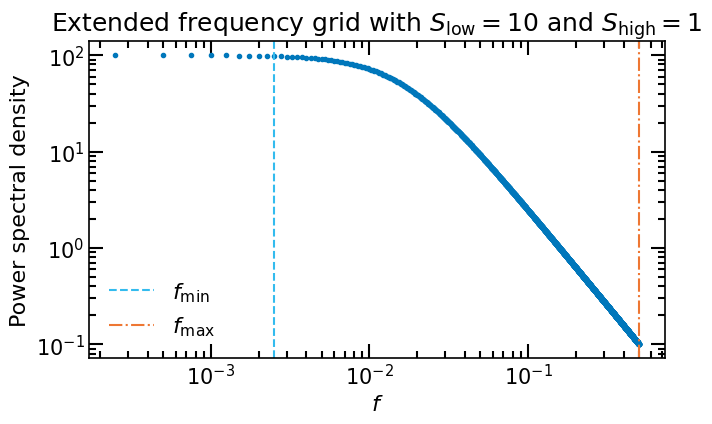

In [17]:
S_low = 10
S_high = 1

f0 = f_min/S_low
df = f0
fN = f_max*S_high # max frequency
# grid of frequencies, from 0 to fend-df with step size df
f = np.arange(0,fN,f0)
# number of points in the psd including the zeroth freq
N = len(f)
# define the parameters of the psd
A , sigma = 1 , 1e-1

P = Expo_PSD(f,A,sigma)

fig,ax = plt.subplots(1,1,figsize=(7,4.5))
ax.plot(f,P,'.')
ax.set_xlabel(r'$f$')
ax.set_ylabel('Power spectral density')
ax.loglog()
ax.set_title("Extended frequency grid with $S_\mathrm{low}=%i$ and $S_\mathrm{high}=%i$"%(S_low,S_high))
ax.axvline(f_min,ls='--',color='C1',label=r'$f_\mathrm{min}$')
ax.axvline(f_max,ls='-.',color='C3',label=r'$f_\mathrm{max}$')
ax.legend()
fig.tight_layout()

As $S_\mathrm{low}$ increases, the error for the first lags decreases very slowly. The error appears to attain a plateau for high values of $\tau$, a plateau which is always the same for all values of $S_\mathrm{low}$ except for $S_\mathrm{low}=2$.  Comparing with the previous figure, we can clearly see that the effect of $S_\mathrm{high}$ is more important than the effect of $S_\mathrm{low}$.

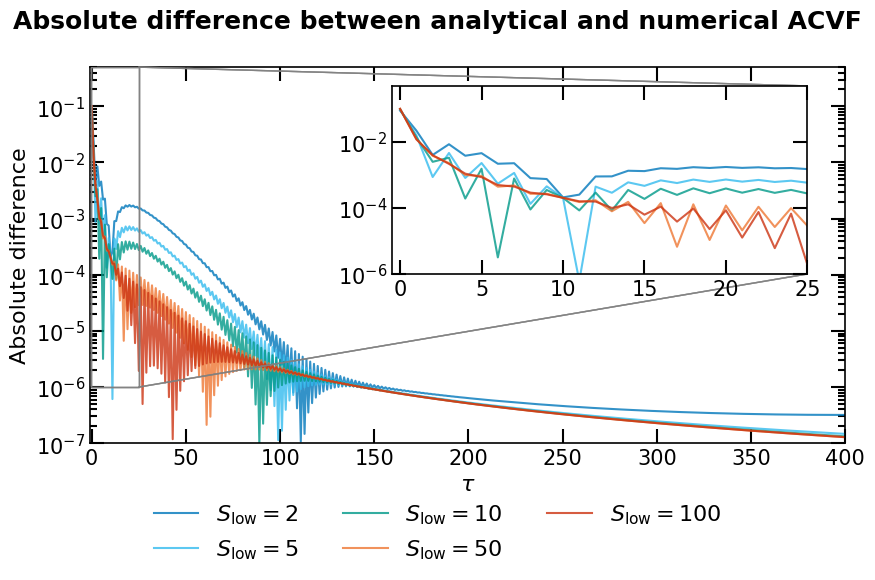

In [18]:
fig,ax = plt.subplots(1,1,figsize=(9,5.5))

for i,S_low in enumerate([2,5,10,50,100]):

    f0 = f_min/S_low
    df = f0
    fN = f_max*S_high # max frequency
    # grid of frequencies, from 0 to fend-df with step size df
    f = np.arange(0,fN,f0)
    # number of points in the psd including the zeroth freq
    N = len(f)
    # define the parameters of the psd
    A , sigma = 1 , 1e-1

    P = Expo_PSD(f,A,sigma)
    
    if N%2==0:
        N+=1
    tmax = 0.5 / df 
    dt = 1 / df / (N-1) / 2
    t = np.arange(0,tmax+dt,dt)

    R_theo = Expo_ACV(t,A,sigma)

    # compute the IFFT, with a normalisation factor 1/M, M=2*(len(y)-1)
    R_dift = np.fft.irfft(P) 
    # assert (R_dift[1:N-1]-np.flip(R_dift[N:])<np.finfo(float).eps).all(), "The IRFFT did not return a mirrored ACV"
    R_num = R_dift[:N]/dt

    ax.plot(t,np.abs(R_theo-R_num),label=f'$S_\mathrm{{low}}={{{S_low}}}$',alpha=0.8)#,marker='s')
    ax.set_xlabel(r"$\tau$")
    ax.set_ylabel(r"Absolute difference")
    ax.set_yscale('log')
    ax.set_xlim(-1,T)
    ax.set_ylim(1e-7,.5)

    if i==0 : 
        axins = ax.inset_axes([0.4, 0.45, 0.55, 0.5])
    axins.plot(t,np.abs(R_theo-R_num),label=f'$S_\mathrm{{low}}={{{S_low}}}$',alpha=0.8)#,marker='s')
    # subregion of the original image
    x1, x2, y1, y2 = -0.5, 25, 1e-6, .5
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_yscale('log')

    ax.indicate_inset_zoom(axins, edgecolor="grey")
    ax.legend(bbox_to_anchor=(0.5, -0.06), loc="lower center",
                bbox_transform=fig.transFigure, ncol=3)
    
fig.suptitle("Absolute difference between analytical and numerical ACVF")
fig.tight_layout()

## Conclusion

In practice, we should use both $S_\mathrm{low}$ and $S_\mathrm{high}$ to extend the grid of frequencies. The optimal values of $S_\mathrm{low}$ and $S_\mathrm{high}$ depend on the power spectrum but also on the desired time lags, it might be necessary to try several values of $S_\mathrm{low}$ and $S_\mathrm{high}$ to check that the computation of the autocovariance function gives a good estimate of the true autocovariance function.